# ¿Migrar a dónde?

Este proyecto es un análisis de series temporales univariante. Por lo tanto, comparo y predigo el PIB per cápita de Ecuador (mi país actual), Uruguay (el país al que voy) y Estados Unidos (un factor de comparación).

In [1]:
import warnings

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf, pacf

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_excel(
    'C:/Users/crisd/OneDrive/Documentos/Datos.xlsx', index_col=-1)
data.head()


,Uruguay,Ecuador,United States
Year,,,
1950,6526.411002,3364.039135,15911.841386
1951,7585.706657,3392.675772,16814.245548
1952,7111.309089,3614.357036,17094.783559
1953,7361.091362,3734.920304,17586.408652
1954,8003.263100,4044.583879,17226.949559


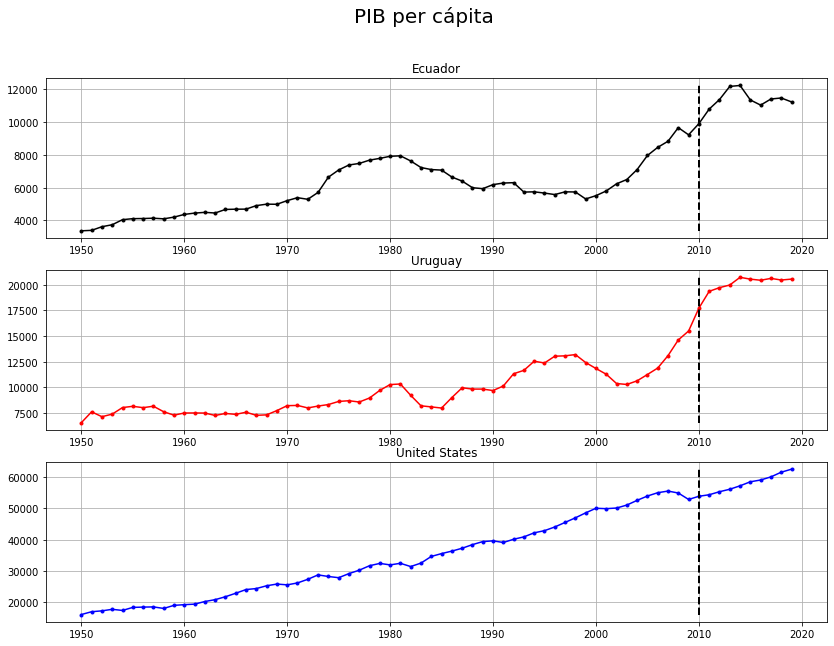

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('PIB per cápita', fontsize=20)

axs[0].plot(data['Ecuador'], '.-k', label='Ecuador')
axs[0].plot([2010, 2010], [min(data['Ecuador']),
            max(data['Ecuador'])], '--k', linewidth=2)

axs[1].plot(data['Uruguay'], '.-r', label='Uruguay')
axs[1].plot([2010, 2010], [min(data['Uruguay']),
            max(data['Uruguay'])], '--k', linewidth=2)

axs[2].plot(data['United States'], '.-b', label='United States')
axs[2].plot([2010, 2010], [min(data['United States']),
            max(data['United States'])], '--k', linewidth=2)

axs[0].set_title('Ecuador')
axs[1].set_title('Uruguay')
axs[2].set_title('United States')

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

plt.show()


### Función de autocorrelación simple (ACF):
$$ acf(k)= \frac{1}{T-k} \sum_{} (Z_{t+k}-\widehat{Z})(Z_t - \widehat{Z}) $$
donde:
$$ \widehat{Z} = \frac{1}{T} \sum_{t} Z_t $$

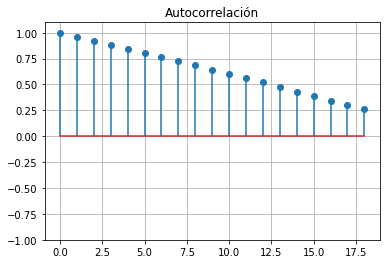

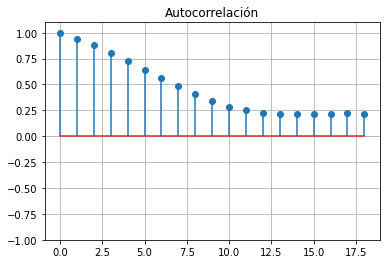

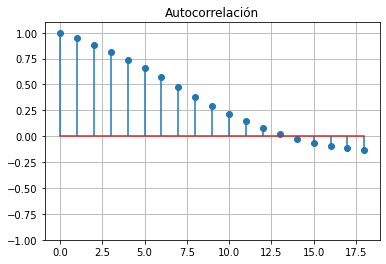

In [4]:
def acf_plot(df):
    acf_data = acf(df, fft=False)
    plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
    plt.title('Autocorrelación')
    plt.ylim(-1, 1.1)
    plt.grid()
    plt.show()


acf_plot(data['United States'])
acf_plot(data['Uruguay'])
acf_plot(data['Ecuador'])


El PIB de los países parece ser dependiente del tiempo, aunque esta dependencia se reduce con el paso del tiempo. Para despejar el efecto de los retardos se calcula la autocorrelación parcial.

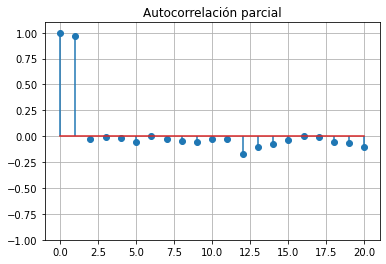

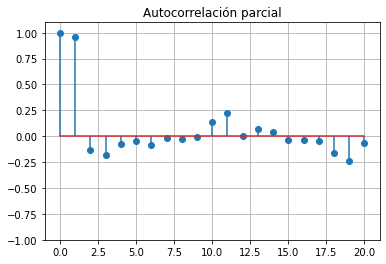

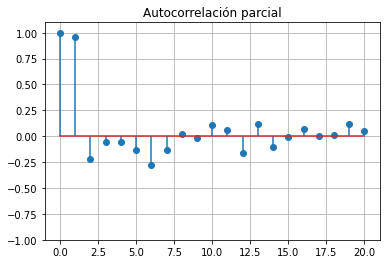

In [5]:
def pacf_plot(df):
    pacf_data = pacf(df, nlags=20)
    plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
    plt.title('Autocorrelación parcial')
    plt.ylim(-1, 1.1)
    plt.grid()
    plt.show()


pacf_plot(data['United States'])
pacf_plot(data['Uruguay'])
pacf_plot(data['Ecuador'])


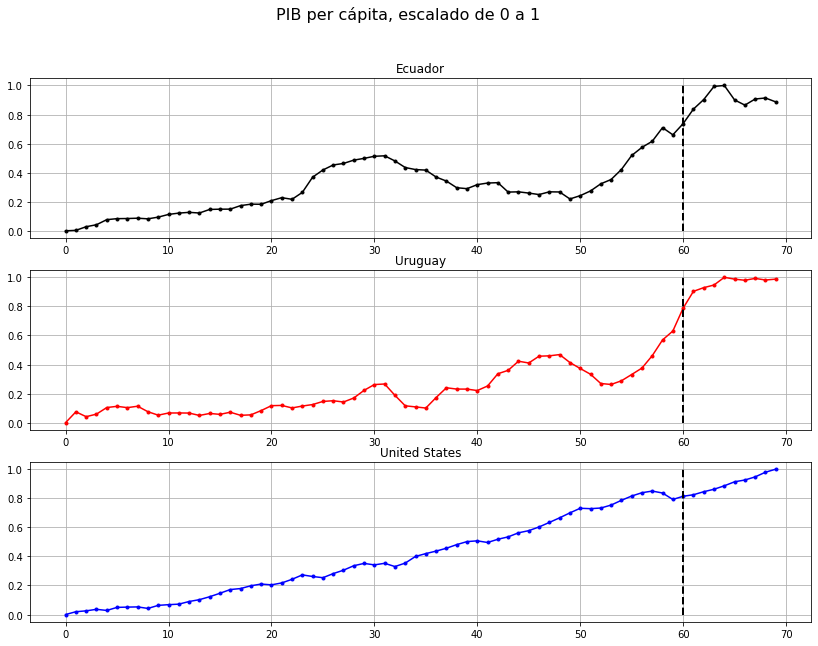

In [6]:
sc = MinMaxScaler()

data_scaled = sc.fit_transform(data)

uru_sc = data_scaled[:, 0]
ecu_sc = data_scaled[:, 1]
us_sc = data_scaled[:, 2]

fig, axs = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('PIB per cápita, escalado de 0 a 1', fontsize=16)

axs[0].plot(ecu_sc, '.-k', label='Ecuador')
axs[0].plot([len(ecu_sc)-10, len(ecu_sc)-10],
            [min(ecu_sc), max(ecu_sc)], '--k', linewidth=2)

axs[1].plot(uru_sc, '.-r', label='Uruguay')
axs[1].plot([len(uru_sc)-10, len(uru_sc)-10],
            [min(uru_sc), max(uru_sc)], '--k', linewidth=2)

axs[2].plot(us_sc,  '.-b', label='United States')
axs[2].plot([len(us_sc)-10, len(us_sc)-10],
            [min(us_sc), max(us_sc)], '--k', linewidth=2)

axs[0].set_title('Ecuador')
axs[1].set_title('Uruguay')
axs[2].set_title('United States')

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

plt.show()

Se interpreta de la siguiente manera:

<li> El PIB per cápita depende de sus valores anteriores, pero esto disminuye con el paso del tiempo (tendencia de largo plazo).</li>
<li> El rezago significativo es el inmediato anterior, luego la dependencia es muy casi nula (no posee tendencia cíclica).</li>

Debido a que no posee un componente cíclico se procede a modelar.

# Modelo Ecuador

Se probó 12 rezagos, la mejor selección fue optar por 2.

In [7]:
P = 2

X_ec = []
for i in range(P - 1, len(data_scaled)-1):
    X_ec.append([ecu_sc[i - n] for n in range(P)])

target_ec = ecu_sc[P:]

In [8]:
X_ec = np.array(X_ec)
target_ec = np.array(target_ec)

input = keras.Input(shape=(P))

layer_1 = layers.Dense(1024, activation='relu')(input)
layer_2 = layers.Dropout(0.2)(layer_1)
layer_3 = layers.Dense(512, activation='relu')(layer_2)
layer_4 = layers.Dense(512, activation='relu')(layer_3)

output = layers.Dense(1, activation='linear')(layer_4)

model_ec = keras.Model(inputs=input, outputs=output)

model_ec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1024)              3072      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 791,041
Trainable params: 791,041
Non-trainable

In [9]:
model_ec.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=100, verbose=0, restore_best_weights=True)

history = model_ec.fit(X_ec[:-10], target_ec[:-10], epochs=100000, verbose=0,
          validation_split=0.2, callbacks=[early_stopping], shuffle=False)


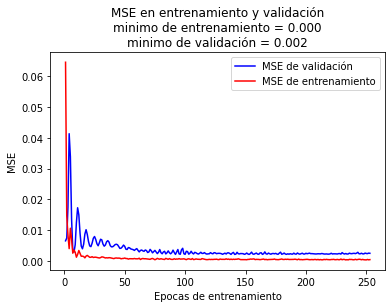

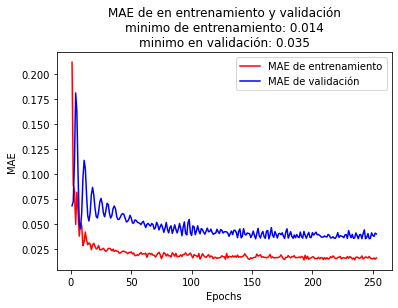

In [10]:
loss_val = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
rec = min(loss)
rec_val = min(loss_val)

plt.plot(epochs, loss_val, 'b', label='MSE de validación')
plt.plot(epochs, loss, 'r', label='MSE de entrenamiento')
plt.title(
    f'MSE en entrenamiento y validación\nminimo de entrenamiento = {rec:.3f}\nminimo de validación = {rec_val:.3f}')
plt.xlabel('Epocas de entrenamiento')
plt.ylabel('MSE')
plt.legend()
plt.show()

mae_val = history.history['val_mae']
mae = history.history['mae']

rec = min(mae)
rec_val = min(mae_val)
plt.plot(epochs, mae, 'r', label='MAE de entrenamiento')
plt.plot(epochs, mae_val, 'b', label='MAE de validación')
plt.title(
    f'MAE de en entrenamiento y validación\nminimo de entrenamiento: {rec:.3f}\nminimo en validación: {rec_val:.3f}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


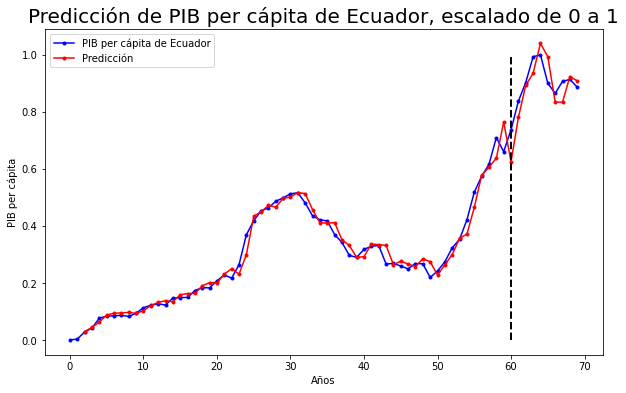

In [11]:
y_hat = model_ec.predict(X_ec)
predict = np.insert(y_hat, 0, np.nan, axis=0)
for i in range(P-1):
    predict = np.insert(predict, 0, np.nan, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(ecu_sc, '.-b', label='PIB per cápita de Ecuador')
plt.plot(predict, '.-r', label='Predicción')

plt.plot([len(ecu_sc)-10, len(ecu_sc)-10],
            [min(ecu_sc), max(ecu_sc)], '--k', linewidth=2)

plt.title('Predicción de PIB per cápita de Ecuador, escalado de 0 a 1', fontsize=20)
plt.xlabel('Años')
plt.ylabel('PIB per cápita')
plt.legend()
plt.show()

y_hat_ec = predict

# Modelo Uruguay

In [12]:
X_uru = []
for i in range(P - 1, len(data_scaled)-1):
    X_uru.append([uru_sc[i - n] for n in range(P)])

target_uru = uru_sc[P:]

In [13]:
X_uru = np.array(X_uru)
target_uru = np.array(target_uru)

input = keras.Input(shape=(P))

layer_1 = layers.Dense(1024, activation='relu')(input)
layer_2 = layers.Dropout(0.2)(layer_1)
layer_3 = layers.Dense(512, activation='relu')(layer_2)
layer_4 = layers.Dense(512, activation='relu')(layer_3)

output = layers.Dense(1, activation='linear')(layer_4)

model_uru = keras.Model(inputs=input, outputs=output)

model_uru.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              3072      
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 791,041
Trainable params: 791,041
Non-trainab

In [14]:
model_uru.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=100, verbose=0, restore_best_weights=True)

history = model_uru.fit(X_uru[:-10], target_uru[:-10], epochs=100000, verbose=0,
          validation_split=0.2, callbacks=[early_stopping], shuffle=False)

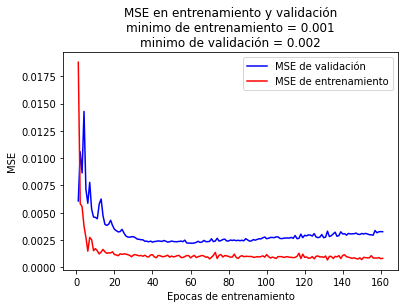

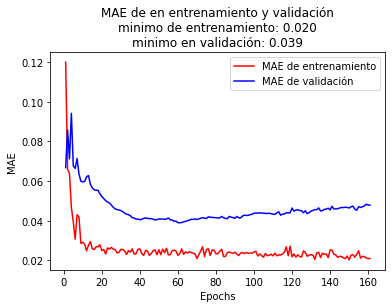

In [15]:
loss_val = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
rec = min(loss)
rec_val = min(loss_val)

plt.plot(epochs, loss_val, 'b', label='MSE de validación')
plt.plot(epochs, loss, 'r', label='MSE de entrenamiento')
plt.title(
    f'MSE en entrenamiento y validación\nminimo de entrenamiento = {rec:.3f}\nminimo de validación = {rec_val:.3f}')
plt.xlabel('Epocas de entrenamiento')
plt.ylabel('MSE')
plt.legend()
plt.show()

mae_val = history.history['val_mae']
mae = history.history['mae']

rec = min(mae)
rec_val = min(mae_val)
plt.plot(epochs, mae, 'r', label='MAE de entrenamiento')
plt.plot(epochs, mae_val, 'b', label='MAE de validación')
plt.title(
    f'MAE de en entrenamiento y validación\nminimo de entrenamiento: {rec:.3f}\nminimo en validación: {rec_val:.3f}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


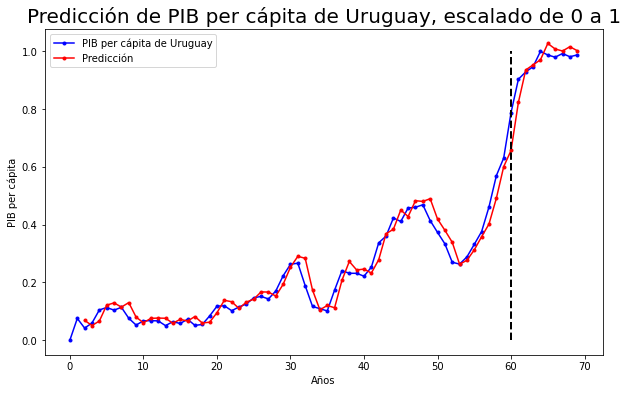

In [16]:
y_hat = model_uru.predict(X_uru)
predict = np.insert(y_hat, 0, np.nan, axis=0)
for i in range(P-1):
    predict = np.insert(predict, 0, np.nan, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(uru_sc, '.-b', label='PIB per cápita de Uruguay')
plt.plot(predict, '.-r', label='Predicción')

plt.plot([len(uru_sc)-10, len(uru_sc)-10],
            [min(uru_sc), max(uru_sc)], '--k', linewidth=2)

plt.title('Predicción de PIB per cápita de Uruguay, escalado de 0 a 1', fontsize=20)
plt.xlabel('Años')
plt.ylabel('PIB per cápita')
plt.legend()
plt.show()

y_hat_uru = predict

# Modelo Estados Unidos

In [17]:
X_us = []
for i in range(P - 1, len(data_scaled)-1):
    X_us.append([us_sc[i - n] for n in range(P)])

target_us = us_sc[P:]


In [18]:
X_us = np.array(X_us)
target_us = np.array(target_us)

input = keras.Input(shape=(P))

layer_1 = layers.Dense(1024, activation='relu')(input)
layer_2 = layers.Dropout(0.2)(layer_1)
layer_3 = layers.Dense(512, activation='relu')(layer_2)
layer_4 = layers.Dense(512, activation='relu')(layer_3)

output = layers.Dense(1, activation='linear')(layer_4)

model_us = keras.Model(inputs=input, outputs=output)

model_us.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              3072      
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 791,041
Trainable params: 791,041
Non-trainab

In [19]:
model_us.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=100, verbose=0, restore_best_weights=True)

history = model_us.fit(X_us[:-10], target_us[:-10], epochs=100000, verbose=0,
          validation_split=0.2, callbacks=[early_stopping], shuffle=False)

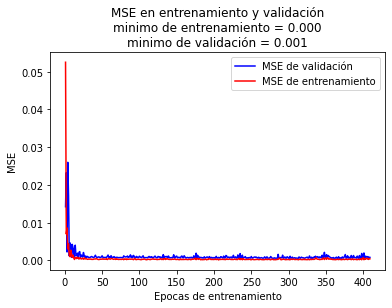

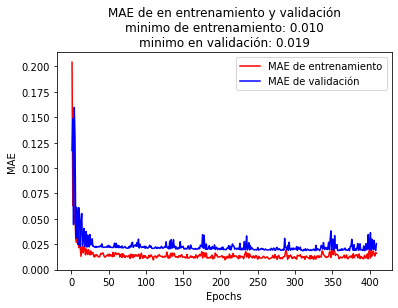

In [20]:
loss_val = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
rec = min(loss)
rec_val = min(loss_val)

plt.plot(epochs, loss_val, 'b', label='MSE de validación')
plt.plot(epochs, loss, 'r', label='MSE de entrenamiento')
plt.title(
    f'MSE en entrenamiento y validación\nminimo de entrenamiento = {rec:.3f}\nminimo de validación = {rec_val:.3f}')
plt.xlabel('Epocas de entrenamiento')
plt.ylabel('MSE')
plt.legend()
plt.show()

mae_val = history.history['val_mae']
mae = history.history['mae']

rec = min(mae)
rec_val = min(mae_val)
plt.plot(epochs, mae, 'r', label='MAE de entrenamiento')
plt.plot(epochs, mae_val, 'b', label='MAE de validación')
plt.title(
    f'MAE de en entrenamiento y validación\nminimo de entrenamiento: {rec:.3f}\nminimo en validación: {rec_val:.3f}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

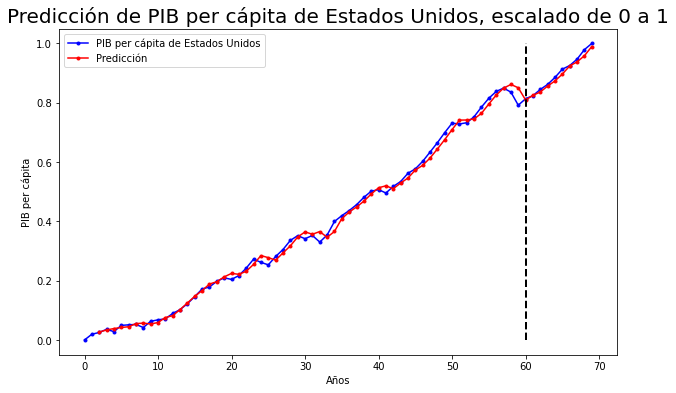

In [21]:
y_hat = model_us.predict(X_us)
predict = np.insert(y_hat, 0, np.nan, axis=0)
for i in range(P-1):
    predict = np.insert(predict, 0, np.nan, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(us_sc, '.-b', label='PIB per cápita de Estados Unidos')
plt.plot(predict, '.-r', label='Predicción')

plt.plot([len(us_sc)-10, len(us_sc)-10],
            [min(us_sc), max(us_sc)], '--k', linewidth=2)

plt.title('Predicción de PIB per cápita de Estados Unidos, escalado de 0 a 1', fontsize=20)
plt.xlabel('Años')
plt.ylabel('PIB per cápita')
plt.legend()
plt.show()

y_hat_us = predict

# Interpretación de las predicciones

In [22]:
y_hat = np.concatenate((y_hat_uru, y_hat_ec, y_hat_us), axis=1)
predict = sc.inverse_transform(y_hat)
predict = pd.DataFrame(
    predict, columns=['Uruguay', 'Ecuador', 'Estados Unidos'], index=data.index)


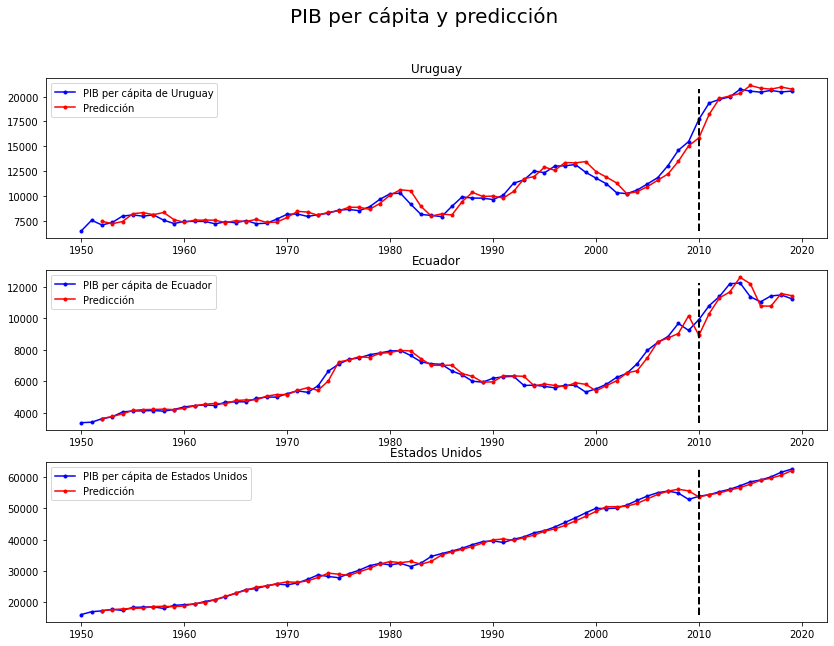

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('PIB per cápita y predicción', fontsize=20)

axs[0].plot(data['Uruguay'], '.-b', label='PIB per cápita de Uruguay')
axs[0].plot(predict['Uruguay'], '.-r', label='Predicción')
axs[0].set_title('Uruguay')
axs[0].plot([2010, 2010], [min(data['Uruguay']),
            max(data['Uruguay'])], '--k', linewidth=2)
axs[0].legend()

axs[1].plot(data['Ecuador'], '.-b', label='PIB per cápita de Ecuador')
axs[1].plot(predict['Ecuador'], '.-r', label='Predicción')
axs[1].set_title('Ecuador')
axs[1].plot([2010, 2010], [min(data['Ecuador']),
            max(data['Ecuador'])], '--k', linewidth=2)
axs[1].legend()

axs[2].plot(data['United States'], '.-b', label='PIB per cápita de Estados Unidos')
axs[2].plot(predict['Estados Unidos'], '.-r', label='Predicción')
axs[2].set_title('Estados Unidos')
axs[2].plot([2010, 2010], [min(data['United States']),
            max(data['United States'])], '--k', linewidth=2)
axs[2].legend()
plt.show()


# Predicción de 10 años en el futuro

In [24]:
def prediction(target, model, data):
    new_data = np.array([])
    new_data = np.append(new_data, [target[-1], target[-2]]).reshape(-1, 2)
    new_data = np.append(new_data, [model.predict(new_data)[
        0][0], target[-1]]).reshape(-1, 2)

    for i in range(10):
        new_data = np.append(new_data, [model.predict(
            new_data[-1].reshape(-1, 2))[0][0], new_data[-1][0]]).reshape(-1, 2)

    pred = new_data.reshape(-1,)
    pred = np.concatenate((data, pred[1:]), axis=0)
    return pred


pred_ec = prediction(target_ec, model_ec, ecu_sc).reshape(-1,1)
pred_uru = prediction(target_uru, model_uru, uru_sc).reshape(-1,1)
pred_us = prediction(target_us, model_us, us_sc).reshape(-1,1)

pred = np.concatenate((pred_uru, pred_ec, pred_us), axis=1)
predict = sc.inverse_transform(pred[-70:])
linspace = np.linspace(min(data.index)+23, max(data.index)+23, len(predict))
predict = pd.DataFrame(
    predict, columns=['Uruguay', 'Ecuador', 'Estados Unidos'], index=linspace)

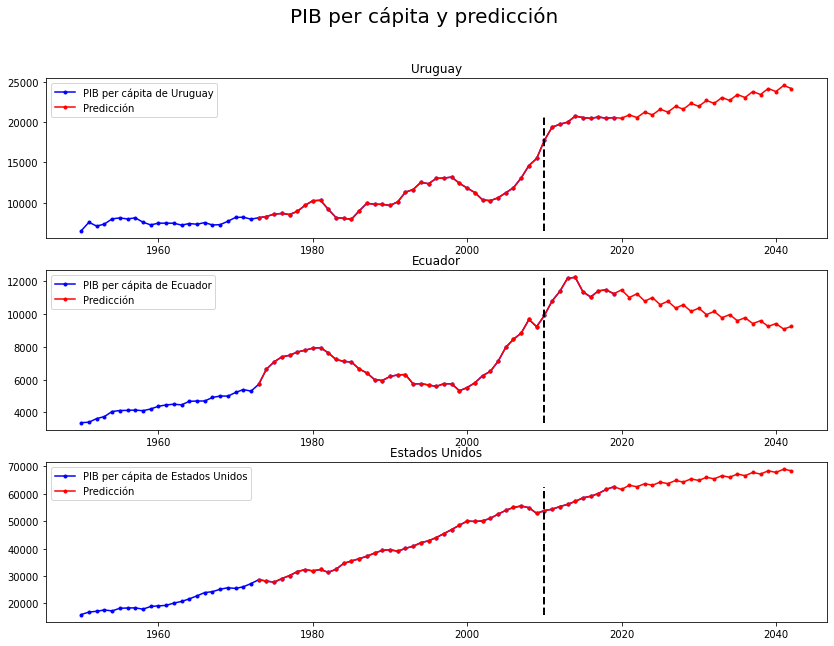

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('PIB per cápita y predicción', fontsize=20)

axs[0].plot(data['Uruguay'], '.-b', label='PIB per cápita de Uruguay')
axs[0].plot(predict['Uruguay'], '.-r', label='Predicción')
axs[0].set_title('Uruguay')
axs[0].plot([2010, 2010], [min(data['Uruguay']),
            max(data['Uruguay'])], '--k', linewidth=2)
axs[0].legend()

axs[1].plot(data['Ecuador'], '.-b', label='PIB per cápita de Ecuador')
axs[1].plot(predict['Ecuador'], '.-r', label='Predicción')
axs[1].set_title('Ecuador')
axs[1].plot([2010, 2010], [min(data['Ecuador']),
            max(data['Ecuador'])], '--k', linewidth=2)
axs[1].legend()

axs[2].plot(data['United States'], '.-b', label='PIB per cápita de Estados Unidos')
axs[2].plot(predict['Estados Unidos'], '.-r', label='Predicción')
axs[2].set_title('Estados Unidos')
axs[2].plot([2010, 2010], [min(data['United States']),
            max(data['United States'])], '--k', linewidth=2)
axs[2].legend()
plt.show()

Conclusión: Emigremos